In [20]:
!pip install parsivar

In [21]:
import numpy as np
np.random.randint(25)

7

In [22]:
import pandas as pd
from parsivar import Tokenizer,FindStems,Normalizer
import os 
import re 
import torch 
from torch import nn
from torch.utils.data import TensorDataset
import math

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
class Args:
  def __init__(self,batch_size,hidden_dim,vocab_l,window):
    self.batch_size = batch_size
    self.hidden_dim = hidden_dim
    self.vocab_l = vocab_l
    self.window = window
    self.dis_init = "uniform"
    self.gen_init ="uniform"
    if torch.cuda.is_available() and torch.cuda.device_count() > 0:
        self.gpu = int(True)
    else:
        self.gpu = int(False)


In [25]:
class Data_load:
  def __init__(self,max_length, step):
    # self.train_path = train_path
    # self.test_path = test_path
    # self.test_sequence = self.read_data(test_path)
    self.vocab = []
    # self.voocab_l = len(self.vocab)
    self.max_length = max_length
    self.step = step
    self.load_dictionary()

  def load_dictionary(self):
    words = open("/content/drive/MyDrive//NLU_Project/vocab.txt").read().split("\n")  
    for w in words:
      self.vocab.append(w)
    # self.vocab.append("\n")    
    # self.vocab.append("\t")  
    self.vocab.append("eos")
    self.vocab.append("sep")
    self.vocab.append("PAD")
    self.vocab.append("UNK")  
    self.vocab.append("BOS")  
    self.vocab = sorted(self.vocab)
    self.dict_word2id = { word :i   for i,word in enumerate(self.vocab)}
    self.dict_id2word = { i : word  for i,word in enumerate(self.vocab)}
    # self.dict_word2id ['PAD'] = 0
    # self.dict_word2id ["UNK"] = 2
    # self.dict_word2id ["BOS"] = 1
    # self.dict_word2id ["sep"] = 3
    # self.dict_word2id ["eos"] = 4
    # self.dict_id2word[0]="PAD"
    # self.dict_id2word[2] ="UNK"
    # self.dict_id2word[1] ="BOS"
    # self.dict_id2word[3] ="sep"
    # self.dict_id2word[4] ="eos"
    self.vocab_l = len(self.vocab)
    
  def create_sequence_data(self,paths):
    poems =  self.read_data(paths)
    all_poem_seq = []
    for poem_seq in poems:
        word2id_sequence = []
        words_list = poem_seq.split(" ")
        # print(words_list)
        for word in words_list:

          try:
              word2id_sequence.append(self.dict_word2id[word])
          except KeyError:
              word2id_sequence.append(self.dict_word2id["UNK"])
        all_poem_seq.append(word2id_sequence)
    X_gen = []
    X_dis = []
    Y = []
    for poem_seq in all_poem_seq:
      for i in range(self.max_length,len(poem_seq),self.step):
         X_gen.append([1]+poem_seq[i - self.max_length: i-1])
         X_dis.append(poem_seq[i - self.max_length: i])
         Y.append(poem_seq[i - self.max_length+1: i+1])
    return X_gen, X_dis, Y
            
  def read_data(self,paths):
    poems_sequence = []
    poems = pd.read_csv(paths[0])
    i = 1
    while True:
            poem_i = poems[poems['poem_id'] == i]
            # print(poem_i)
            index_i = poems.index[poems['poem_id'] == i]
            current_poem = ""
            for p in index_i:
                v_position = poem_i.loc[p,"v_position"]
                verse =  poem_i.loc[p,"poem_text"]
                # print(verse)
                current_poem += verse 
                if v_position == 0:
                    current_poem += " sep"
                if v_position == 1:
                    current_poem += " eos"
            if len(current_poem)>0:
              poems_sequence.append(current_poem)
            i += 1
            if i>599 :
              break
    for path in paths[1:]:
        
        poems = pd.read_csv(path)
        # print(poems['poem_id'])
        i = 1
        while True:
            poem_i = poems[poems['poem_id'] == i]
          
            index_i = poems.index[poems['poem_id'] == i]
            current_poem = ""
            for p in index_i:
                v_position = poem_i.loc[p,"v_position"]
                verse =  poem_i.loc[p,"poem_text"]
                current_poem += verse 
                if v_position == 0:
                    current_poem += " sep"
                if v_position == 1:
                    current_poem += " eos"
            poems_sequence.append(current_poem)
            i += 1
            if len(poem_i)<1 :
              break
    return poems_sequence

In [26]:
%%time
import os
import pandas as pd
paths = os.listdir("/content/drive/MyDrive/NLU_Project/Data/poems")
paths_arr = ["/content/drive/MyDrive/NLU_Project/Data/poems/" + f for f in paths]
d_load = Data_load(30,1)
# poems_list = d_load.read_data(["/content/drive/MyDrive/NLU_Project/Data/train.csv"]+paths_arr)
# poems_list = d_load.read_data(["/content/drive/MyDrive/NLU_Project/Data/train.csv"])
args = Args(32,40,d_load.vocab_l,d_load.max_length)

CPU times: user 745 µs, sys: 3.03 ms, total: 3.78 ms
Wall time: 9.81 ms


In [27]:
len(list(d_load.dict_id2word.keys()))

1817

In [28]:
# # from parsivar import Normalizer
# import re
# from parsivar import Tokenizer
# my_normalizer = Normalizer()
# my_tokenizer = Tokenizer()
# words = {}
# for poems in poems_list:
#   poems = re.sub("[0-9a-z]|\!|\?|\.|\،","",poems)
#   tokens = my_tokenizer.tokenize_words(my_normalizer.normalize(poems))
#   for token in tokens:
#     try:
#        words[token] +=1
#     except KeyError:
#       words[token] =1

In [29]:
# f = open("/content/drive/MyDrive/NLU_Project/vocab_text.txt",'w')
# for w in list(words.keys()):
#     f.write(w)
#     f.write("\n")
# f.close()

In [30]:
X_gen,X_dis,Y= d_load.create_sequence_data( [
                                             "/content/drive/MyDrive/NLU_Project/Data/train.csv",
                                             "/content/drive/MyDrive/NLU_Project/Data/poems/سعدی.csv"])
len(X_gen)

206162

In [40]:
from torch.utils.data import DataLoader
dataset_gen = TensorDataset(torch.tensor(X_gen[:10000]),torch.tensor(Y[:10000]))
dataloader_gen = DataLoader(dataset_gen, batch_size=args.batch_size)
dataset_dis = TensorDataset(torch.tensor(X_dis[:10000]),torch.tensor(Y[:10000]))
dataloader_dis = DataLoader(dataset_dis, batch_size=args.batch_size)

In [32]:
# f = open("/content/drive/MyDrive/NLU_Project/vocab_text.txt","w")
# for i in d_load.vocab:
#   f.write(i)
#   f.write("\n")
# f.close()

In [33]:
import abc
 

class Metrics:
    __metaclass__ = abc.ABCMeta
    def __init__(self, name='Metric'):
        self.name = name

    def get_name(self):
        return self.name

    def set_name(self, name):
        self.name = name

    
    @abc.abstractmethod
    def get_score(self):
        pass

    
    @abc.abstractmethod
    def reset(self):
        pass

class NLL(Metrics):
    def __init__(self, name, model, loader, gpu=True):
        super(NLL, self).__init__(name)

        self.model = model
        self.loader = loader
        self.gpu = gpu
        self.need_reset = True

    def get_score(self, model=None, loader=None, ignore=False):
        """note that NLL score need the updated model and data loader each time, use reset() before get_score()"""
        if ignore:
            return 0
        if model and loader:
            self.reset(model, loader)
        assert not self.need_reset, 'need reset model and loader before calculating NLL'
        self.need_reset = True
        return self.cal_nll()

    def reset(self, model, loader):
        self.model = model
        self.loader = loader
        self.need_reset = False

    def cal_nll(self,model):
        total_loss = 0
        criterion = nn.NLLLoss()
        with torch.no_grad():
            for i, data in enumerate(self.loader):
                inp, target = data
                if self.gpu:
                    inp, target = inp.cuda(), target.cuda()
                h,c = self.model.init_state(inp.size()[0])
                pred,_, _, _ = model.forward(inp, (h.to(device),c.to(device)))
                for k in range(inp.size(1)):
                    loss = criterion(pred[:,k,:], target[:,k].view(-1))
                    total_loss += loss.item()
                # print(torch.argmax(pred,dim=2).size(),target.view(-1).size())
                
        return total_loss / len(self.loader)

In [41]:
from posix import X_OK
import torch.nn.functional as F
import torch
from torch import nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.hidden_dim =200
        self.embedding_dim = 300
        self.num_layers = 3
        self.temperature = 0.1
        n_vocab = args.vocab_l
        self.embeddings = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
           self.embedding_dim, self.hidden_dim, batch_first=True,
           
        )
        self.fc = nn.Linear(self.hidden_dim, n_vocab)
        # self.init_params()

    def init_params(self):
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 0:
                stddev = 1 / math.sqrt(param.shape[0])
                if args.dis_init == 'uniform':
                    torch.nn.init.uniform_(param, a=-0.05, b=0.05)
                elif args.dis_init == 'normal':
                    torch.nn.init.normal_(param, std=stddev)
    def forward(self, inp, hidden,need_hidden= False):
        self.theta = []
        if args.gpu:
                inp = inp.cuda()
        emb = self.embeddings(inp)  # batch_size * len * embedding_dim
        if len(inp.size()) == 1:
                   emb = emb.unsqueeze(1)  # batch_size * 1 * embedding_dim
        out, hidden = self.lstm(emb, hidden)
        out = self.fc(out.squeeze(1)) 
        out = F.softmax(out, dim=-1)
        # out.retain_grad()
        self.theta.append(out)
        gumbel_t = self.add_gumbel(out)
        next_token = torch.argmax(gumbel_t*self.temperature, dim=1)
        pred = F.softmax(gumbel_t * self.temperature, dim=-1)  # batch_size * vocab_size
        next_token_onehot = None
        return pred, hidden, next_token, next_token_onehot
       

    def sample_generate(self,inp,hidden,one_hot=False):
      inp =torch.randint(0,args.vocab_l,(inp.size()[0],)).long()
      batch_size = inp.size()[0]   
      samples = torch.zeros( inp.size()[0], args.window).long()
      if one_hot:
            all_preds = torch.zeros( inp.size()[0], args.window, args.vocab_l)
            if args.gpu:
                all_preds = all_preds.cuda()
      for i in range(args.window):
                pred, hidden, next_token, next_token_onehot = self.forward(inp,hidden) 
                if one_hot:
                    all_preds[:, i] = pred
                samples[0:batch_size, i] = next_token
      if one_hot:
            return all_preds  # batch_size * seq_len * vocab_size
      return samples


    def add_gumbel(self,theta, eps=1e-10, gpu=args.gpu):
        u = torch.zeros(theta.size())
        if gpu:
            u = u.cuda()
        u.uniform_(0, 1)
        gumbel_t = torch.log(theta + eps) - torch.log(-torch.log(u + eps) + eps)
        return gumbel_t 


    def init_state(self, batch_size):
        h = torch.zeros(1, batch_size, self.hidden_dim)
        c = torch.zeros(1, batch_size, self.hidden_dim)
        return h, c
     
dis_filter_sizes = [10, 15, 20, 25, 30, 4, 5, 2]
dis_num_filters = [50, 50, 80, 80, 80, 50, 50, 50]


class Discriminator(nn.Module):
   def __init__(self):
        super(Discriminator, self).__init__()
        # self.lstm_size = 128
        self.embedding_dim = 300
        self.num_layers = 3
        self.feature_dim = sum(dis_num_filters)
        # self.gpu = gpu
        n_vocab = args.vocab_l
        # self.embeddings = nn.Embedding(
        #     num_embeddings=n_vocab,
        #     embedding_dim=self.embedding_dim,
        # )
        self.embeddings = nn.Linear(args.vocab_l, self.embedding_dim, bias=False)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n, (f, self.embedding_dim)) for (n, f) in zip(dis_num_filters , dis_filter_sizes)
        ])
        self.highway = nn.Linear(self.feature_dim, self.feature_dim)
        self.feature2out = nn.Linear(self.feature_dim, 1)
        self.dropout = nn.Dropout(0.1)
        self.init_params()

   def forward(self, x):
        feature = self.get_feature(x)
        out = self.feature2out(self.dropout(feature))
        pred = nn.Sigmoid()(out.reshape(out.size()[0]))
        return pred

   def get_feature(self, inp):
        emb = self.embeddings(inp).unsqueeze(1) # batch_size * 1 * max_seq_len * embed_dim
        # print(emb.size(),"*********")
        convs = [F.relu(conv(emb)).squeeze(3) for conv in self.convs]  # [batch_size * num_filter * length]
        pools = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in convs]  # [batch_size * num_filter]
        pred = torch.cat(pools, 1)  # tensor: batch_size * feature_dim
        highway = self.highway(pred)
        pred = torch.sigmoid(highway) * F.relu(highway) + (1. - torch.sigmoid(highway)) * pred  # highway
        return pred

   def init_params(self):
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 0:
                stddev = 1 / math.sqrt(param.shape[0])
                if args.dis_init == 'uniform':
                    torch.nn.init.uniform_(param, a=-0.05, b=0.05)
                elif args.dis_init == 'normal':
                    torch.nn.init.normal_(param, std=stddev)

In [35]:
import numpy as np
import torch
import torch.nn as nn
from abc import abstractmethod
import math
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim

In [42]:
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from typing import List, Optional


class SGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, *, maximize=False, foreach: Optional[bool] = None):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        maximize=maximize, foreach=foreach)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            has_sparse_grad = False
            i = 0 
            for p in group['params']:
               
                if p.grad is not None:
                    i += 1
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)
                    if p.grad.is_sparse:
                        has_sparse_grad = True

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            sgd(params_with_grad,
                d_p_list,
                momentum_buffer_list,
                weight_decay=group['weight_decay'],
                momentum=group['momentum'],
                lr=group['lr'],
                dampening=group['dampening'],
                nesterov=group['nesterov'],
                maximize=group['maximize'],
                has_sparse_grad=has_sparse_grad,
                foreach=group['foreach'])

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss


def sgd(params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
        # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
        has_sparse_grad: bool = None,
        foreach: bool = None,
        *,
        weight_decay: float,
        momentum: float,
        lr: float,
        dampening: float,
        nesterov: bool,
        maximize: bool):
    r"""Functional API that performs SGD algorithm computation.

    See :class:`~torch.optim.SGD` for details.
    """

    if foreach is None:
        # Placeholder for more complex foreach logic to be added when value is not set
        foreach = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with foreach optimizers')

    if foreach and not torch.jit.is_scripting():
        func = _multi_tensor_sgd
    else:
        func = _single_tensor_sgd
    # print( func )
    func(params,
         d_p_list,
         momentum_buffer_list,
         weight_decay=weight_decay,
         momentum=momentum,
         lr=lr,
         dampening=dampening,
         nesterov=nesterov,
         has_sparse_grad=has_sparse_grad,
         maximize=maximize)

def _single_tensor_sgd(params: List[Tensor],
                       d_p_list: List[Tensor],
                       momentum_buffer_list: List[Optional[Tensor]],
                       *,
                       weight_decay: float,
                       momentum: float,
                       lr: float,
                       dampening: float,
                       nesterov: bool,
                       maximize: bool,
                       has_sparse_grad: bool):

    for i, param in enumerate(params):

        d_p = d_p_list[i]
        if weight_decay != 0:
            d_p = d_p.add(param, alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        alpha = lr if maximize else -lr
        # pre_p = param.clone()
        param.add_(d_p, alpha=alpha)
        # print(pre_p - param)


def _multi_tensor_sgd(params: List[Tensor],
                      grads: List[Tensor],
                      momentum_buffer_list: List[Optional[Tensor]],
                      *,
                      weight_decay: float,
                      momentum: float,
                      lr: float,
                      dampening: float,
                      nesterov: bool,
                      maximize: bool,
                      has_sparse_grad: bool):

    if len(params) == 0:
        return

    if has_sparse_grad is None:
        has_sparse_grad = any([grad.is_sparse for grad in grads])

    if weight_decay != 0:
        grads = torch._foreach_add(grads, params, alpha=weight_decay)

    if momentum != 0:
        bufs = []

        all_states_with_momentum_buffer = True
        for i in range(len(momentum_buffer_list)):
            if momentum_buffer_list[i] is None:
                all_states_with_momentum_buffer = False
                break
            else:
                bufs.append(momentum_buffer_list[i])

        if all_states_with_momentum_buffer:
            torch._foreach_mul_(bufs, momentum)
            torch._foreach_add_(bufs, grads, alpha=1 - dampening)
        else:
            bufs = []
            for i in range(len(momentum_buffer_list)):
                if momentum_buffer_list[i] is None:
                    buf = momentum_buffer_list[i] = torch.clone(grads[i]).detach()
                else:
                    buf = momentum_buffer_list[i]
                    buf.mul_(momentum).add_(grads[i], alpha=1 - dampening)

                bufs.append(buf)

        if nesterov:
            torch._foreach_add_(grads, bufs, alpha=momentum)
        else:
            grads = bufs

    alpha = lr if maximize else -lr
    if not has_sparse_grad:
        torch._foreach_add_(params, grads, alpha=alpha)
    else:
        # foreach APIs dont support sparse
        for i in range(len(params)):
            params[i].add_(grads[i], alpha=alpha)

cuda
0
[0/10][0/313] Loss_D: 1.3638 Loss_G: 0.6652 NLL_Loss:-0.016518
گرما حرص بی‌منتها تشنه درج برفتی بستان برین بسی چین باش سیف دریای سه گفتی برگ‌تر حرص حرکت نبیندش گذشت پاکیزه‌ست شیفته‌ی بازیچه‌ی کریجی یقینت صورت خیالت پا آنات بپوشیش 
[0/10][100/313] Loss_D: 1.3665 Loss_G: 0.6650 NLL_Loss:-0.016522
شمع نه‌گر سپارم نیارد حباب معمور همخانه تمامی مژگان یقینت زمستان کافرینت برو سایه فریبنده سوادش لطیف نور‌بودی آخر خاص بی‌نیازی تباهی خاست لفظ شربت پراکنده شمع ثریاست الصلا تنزیل 
[0/10][200/313] Loss_D: 1.3647 Loss_G: 0.6647 NLL_Loss:-0.016511
خدم بباید وز فتحه بی‌خردان غمدان کردار داغ شانه نیابند گسار جسمها پرس سکون شسته دوست خانه‌دار کژبین‌شده‌با رسوا عود غمدان سبزی ازو رستنی وا کردند رسید قمار وزان خواهم 
[0/10][300/313] Loss_D: 1.3634 Loss_G: 0.6643 NLL_Loss:-0.016503
زشوق مژگان آفرید محنت پوش آر وانمودند همینها‌بود گفتم محفل تعمیر سکه زهد جبین فروزی لقا کشت تابد چترش برنا اولا جنس ناپیدا کرد بی‌منتها اظهار صدر نجوید فرود کس 
1
[1/10][0/313] Loss_D: 1.3575 Loss_G: 0.6646 NLL_Loss:-0.0

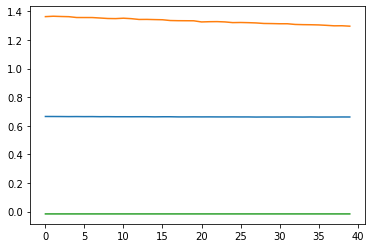

In [44]:
netD = Discriminator()
netG = Generator()
optimizerD = SGD(netD.parameters(), lr = 0.0001)
optimizerG =SGD(netG.parameters(), lr = 0.0001)
# print(netG.parameters())
criterion = nn.BCELoss()
nllloss = NLL("NLL", netG, dataloader_dis, gpu=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
netD.to(device)
netG.to(device) 
gloss = []
dloss = []
Nloss = []
epochs = 10
for epoch in range(epochs):
  print(epoch)
  i = 0
  for data_gen,data_dis in zip(dataloader_gen,dataloader_dis):
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    # for p1,p2 in zip(pre_param, netG.parameters()):
    #   print(p1.grad == 0)
    real, _ = data_dis
    d_gen, _ = data_gen
    input_g = Variable(d_gen).to(device)
    input = Variable(real).to(device)
    target = Variable(torch.ones(input.size()[0])).to(device)
    state_h, state_c = netG.init_state(input_g.size()[0])
    gen_samples = netG.sample_generate(input_g, (state_h.to(device), state_c.to(device)), one_hot=True)
    if args.gpu:
       real, gen_samples = real.cuda(), gen_samples.cuda()
    real_samples = F.one_hot(real, args.vocab_l).float()
    # real error for discriminator
    output =  torch.reshape(netD(real_samples),(-1,)).to(device)
    errD_real = criterion(output, target)
    ###################################################################
    output = netD(gen_samples)
    # print(output)
    target = Variable(torch.zeros(input_g.size()[0])).to(device)
    errD_fake = criterion(torch.reshape(output, (-1,)), target)
    errD = errD_real + errD_fake
    errD.backward(retain_graph=True)
    optimizerD.step()
    # optimize Generator
    target = Variable(torch.ones(input.size()[0])).to(device)
    output = netD(gen_samples)
    # print(output)
    errG = criterion(torch.reshape(output, (-1,)), target)
    # print(errG)
    errG.backward()
    pre_param = []
   
    if netG is not None:
            torch.nn.utils.clip_grad_norm_(netG.parameters(), 5)
    optimizerG.step()
    if i % 100== 0:
      nlls = nllloss.cal_nll(netG)
      print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f NLL_Loss:%4f' % (epoch, epochs, i, len(dataloader_gen), errD.detach(), errG.detach(),nlls))
      gloss.append(errG.cpu().data.numpy())
      dloss.append(errD.cpu().data.numpy())
      Nloss.append(nlls)
      #vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
      state_h, state_c = netG.init_state(input_g.size()[0])
      fake = netG.sample_generate(input_g.float(),(state_h.to(device), state_c.to(device)))
      # print(fake[0,:])
      str1 = ""
      for o in fake:
        str1 = ""
        for w in o:  
          # print(w)     
          str1 += d_load.vocab[w]
          str1 +=" "
        print(str1)
        break
    i += 1
from matplotlib import pyplot as plt
plt.plot(gloss)
plt.plot(dloss)
plt.plot(Nloss)
plt.show()
      #vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)

In [38]:
torch.randint(3, 5, (1,))

tensor([4])

In [39]:
a.grad

NameError: ignored

In [ ]:
poems = pd.read_csv("/content/drive/MyDrive/NLU_Project/Data/test.csv")
# print(poems['poem_id'])
i = 3
poems_sequence =[]
while True:
            poem_i = poems[poems['poem_id'] == i]
            # print(poem_i)
            index_i = poems.index[poems['poem_id'] == i]
            current_poem = ""
            for p in index_i:
                v_position = poem_i.loc[p,"v_position"]
                verse =  poem_i.loc[p,"poem_text"]
                # print(verse)
                current_poem += verse 
                if v_position == 0:
                    current_poem += " \t"
                if v_position == 1:
                    current_poem += " \n"
            if len(current_poem)>0:
              poems_sequence.append(current_poem)
            i += 1
            if i>596 :
              break


In [ ]:
state_h, state_c = netG.init_state(1)
fake= netG(torch.tensor([[1]]), (state_h, state_c))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
for o in fake:
        str1 = ""
        for w in o:  
          # print(w)     
          str1 += d_load.vocab[w]
          str1 +=" "
          score = 0
          poem = ''
        print(str1)
        for poems in poems_sequence:
          s =  sentence_bleu(poems.split(" "),str1.split(" "))
          if score < s:
           score = s
           poem = poems
        print(score)
        print(poem)
